In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import seaborn

from sklearn import metrics

In [3]:
seaborn.set_style('white')
seaborn.set_palette('colorblind')

Experiments with embeddings
===

## Base implementation
 * loss: average mse between embedding of next exercise and network output
 * hidden_layer_size 200
 * embedding_size 200
 * log_values 50
 * logs_dirname '../results/dkt_lstm/by_problem_id/tensorboard/'
 * batch_size: 50
 * max_num_steps: 100
 * training_epochs 500

### Validation results


In [4]:
lstm_results = pandas.DataFrame([
        [50, -0.326093822718],
        [100, -0.0424702838063],
        [150, -0.0353030189872],
        [200, -0.0305649638176],
        [250, -0.0265223439783],
        [300, -0.0227521844208],
        [350, -0.019143987447],
        [400, -0.015706256032],
        [450, -0.0125677362084],
    ], columns=['iteration', 'r2'])
lstm_results['type'] = 'validation'

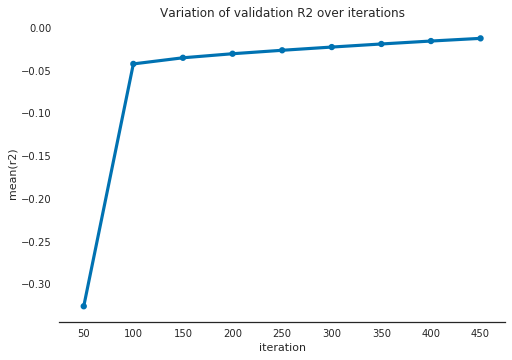

In [5]:
seaborn.pointplot(x="iteration", y="r2", data=lstm_results, markers='.', linestyles='-')
plt.title('Variation of validation R2 over iterations')
seaborn.despine(left=True)
plt.show()

### Testing results

In [6]:
test_prediction_file = '../../results/dkt_lstm/by_problem_id/predictions.p'

with open(test_prediction_file, 'r') as prediction_file:
    predictions = pickle.load(prediction_file)

In [13]:
predictions[0][:2], predictions[1][:2]

(array([ array([ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
         0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  1.,  1.,  1., 

In [7]:
def get_rmse(true, predicted):
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        results.append([metrics.mean_squared_error(true_sequence, 1-predicted_sequence)**0.5,
                        true_sequence.shape[0]])
    return pandas.DataFrame(results, columns=['RMSE', 'Sequence lenght'])

In [8]:
rmse_results = get_rmse(*predictions)

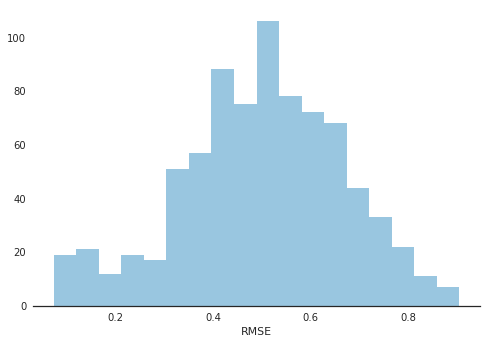

In [12]:
seaborn.distplot(rmse_results.RMSE, kde=False)
seaborn.despine(left=True)

In [10]:
rmse_results.describe()

,RMSE,Sequence lenght
count,800.000000,800.000000
mean,0.499088,73.676250
std,0.167892,148.240642
min,0.072647,1.000000
25%,0.397208,8.000000
50%,0.512161,21.000000
75%,0.617141,67.000000
max,0.904797,1261.000000


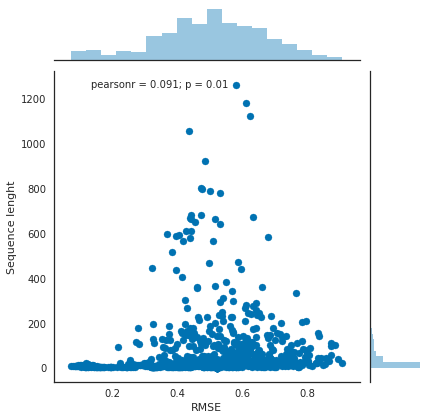

In [11]:
seaborn.jointplot(x='RMSE', y='Sequence lenght', data=rmse_results)